


# Análise exploratória de dados do Titanic

### Resumo
---
 
 [Introdução](#Introdução)

 [Conjunto de dados](#Conjunto-de-dados)
 
 [Ferramentas](#Ferramentas)

 [Questões-chave](#Questões-chave)
 
    - Houve diferença representativa na proporção de pessoas sobreviventes de acordo com o preço pago na passagem?
    - É possível confirmar a crença de que mulheres e crianças são prioridade no salvamento dentre as pessoas passageiras?
    - É possível afirmar que houve uma grande diferença dentre sobreviventes considerando seu local de embarque?
    - Pessoas que viajaram sozinhas tiveram mais chances de sobreviver?

 Considerações

 Divulgação

 [Referências](#Referências)

 ### Introdução
 ...

### Ferramentas

Para análise foi utilizada a linguagem Python e suas bibliotecas: **pandas** para estrutura e manipulação de dados; **numpy** para operação com matrizes e vertores; **matplotlib** e **seaborn** para visualização de dados; **funções personalizadas** para manipulação dos dados; **formatação de tabela** personalizada para aprimorar a exibição dos dados.

In [1]:
# bibliotecas usadas para análise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

# bibliotecas usadas para análise
from data.data_modules import data_manipulation_functions as dm
from data.data_modules import data_plot_functions as pf
from data.data_modules import data_table_format as tab

### Conjunto de dados

#### Fonte
A análise foi feita com os dados fornecidos pela Udacity a partir de uma amostra do site Kaggle.  
Para mais detalhes, esse é o link para a fonte dos dados https://www.kaggle.com/c/titanic/data

#### Preparação dos dados
Para deixar os dados mais legíveis e consistentes de modo a preservar a informação, os dados passaram por um processo de limpeza. Durante a execução, algumas colunas foram avaliadas com relação à qualidade e pertinência de serem utilizadas na análise. Assim, dentre as 12 colunas foram delimitadas as seguintes 10 colunas:
> **survived** (informa se sobreviveu), **ticket_class** (classe), **name** (nome), **gender** (sexo), **age** (idade), **siblings_or_spouses** (quantidade de irmãs(ãos) ou  cônjuges), **parents_or_children** (quantidade de pais ou filhas(os)), **ticket_number** (número do bilhete), **fare** (custo) e **embarkation_city** (cidade de embarque)

Dentre as colunas, a que contém os dados referentes a idade possuia cerca de 80% dos dados completos. Para permitir cruzamentos entre outras variáveis, os cerca de 20% de dados foram preenchidos de modo randômico de modo a preservar a proporção de diferençãs de idade dos dados completos.

O passo a passo realizado pode ser verificado em [/data/data_wrangling.ipynb](./data/data_wrangling.ipynb)

In [2]:
# carregamento dos dados
data_titanic = pd.read_csv('./data/data_titanic_clean')

# exibição das 3 primeiras linhas do conjunto de dados
tab.format_table(data_titanic.head(10))

,name,age,gender,ticket_class,fare,ticket_number,embarkation_city,siblings_or_spouses,parents_or_children,survived
0,"Braund, Mr. Owen Harris",22,male,third,7.25,A/5 21171,Southampton,1,0,no
1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",38,female,first,71.2833,PC 17599,Cherbourg,1,0,yes
2,"Heikkinen, Miss. Laina",26,female,third,7.925,STON/O2. 3101282,Southampton,0,0,yes
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,female,first,53.1,113803,Southampton,1,0,yes
4,"Allen, Mr. William Henry",35,male,third,8.05,373450,Southampton,0,0,no
5,"Moran, Mr. James",20.9,male,third,8.4583,330877,Queestown,0,0,no
6,"McCarthy, Mr. Timothy J",54,male,first,51.8625,17463,Southampton,0,0,no
7,"Palsson, Master. Gosta Leonard",2,male,third,21.075,349909,Southampton,3,1,no
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27,female,third,11.1333,347742,Southampton,0,2,yes
9,"Nasser, Mrs. Nicholas (Adele Achem)",14,female,second,30.0708,237736,Cherbourg,1,0,yes


#### Descrição da amostra
A amostra contém **891** dados que representam cerca de **20%** da quantidade total de **2224** referentes às pessoas presentes no navio. Por possuir apenas informações sobre a classe do tipo de passagem comprada, podemos inferir que essa **amostra é delimitada aos passageiros** do navio o que deixa de fora, assim, informações sobre a tripulação.

### Questões-chave
A investigação feita buscou focar em temas relacionados a idade, gênero e econômico a partir da amostra de dados do Titanic. Para chegar às questões da análise, primeiramente foram elaboradas algumas questões iniciais antes da limpeza dos dados e outras questões depois.
Assim, como resultado, as seguintes questões-chave foram elencadas:

#### Questões iniciais
- Houve diferença representativa na proporção de pessoas sobreviventes de acordo com o preço pago na passagem?
- É possível confirmar a crença de que mulheres e crianças são prioridade no salvamento dentre as pessoas passageiras?

#### Questões a partir da limpeza dos dados
- É possível afirmar que houve uma grande diferença dentre sobreviventes considerando seu local de embarque?
- Pessoas que viajaram sozinhas tiveram mais chances de sobreviver?

In [54]:
# informações básicas do conjunto de dados
titanic_survivors = data_titanic.query('survived == "yes"')
titanic_victims = data_titanic.query('survived == "no"')

color_survivors = '#28b14e'
color_victims = '#b12885'
palette_destiny = {'yes': color_survivors, 'no': color_victims}
palette_classes = {'first': '#8a6d3b','second': '#7e888a', 'third': '#8e5753'}
palette_gender = {'male': '#2798de','female': '#de8f27'}
palette_destiny_classes = {**palette_destiny,**palette_classes}
palette_destiny_gender = {**palette_destiny,**palette_gender}

### Houve diferença representativa na proporção de pessoas sobreviventes de acordo com o preço pago na passagem?

Por meio da distribuição dos valores da passagem, podemos observar a concentração dos valores pagos com relação aos sobreviventes e vítimas.

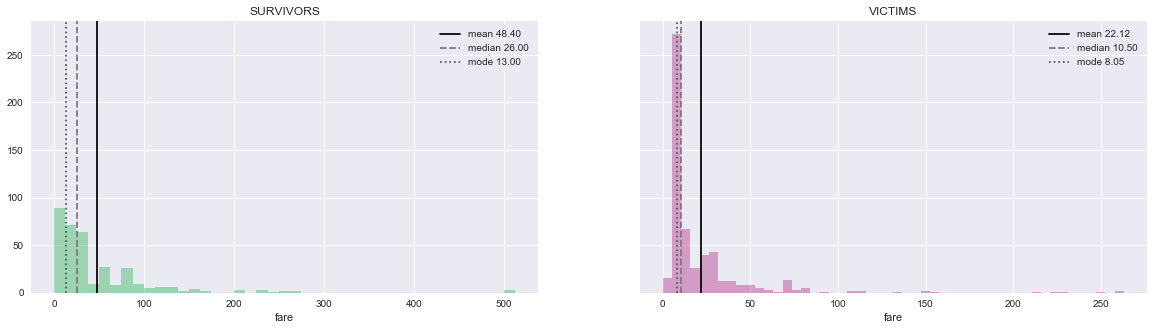

In [38]:
fig_fare_means, ax_fare_means = plt.subplots(1,2, sharex='col', sharey='row', figsize=(20,5))

pf.plot_distribution_with_means(titanic_survivors['fare'], title='survivors', color=color_survivors, ax=ax_fare_means[0])
pf.plot_distribution_with_means(titanic_victims['fare'], title='victims', color=color_victims, ax=ax_fare_means[1])

fig_fare_means.show()

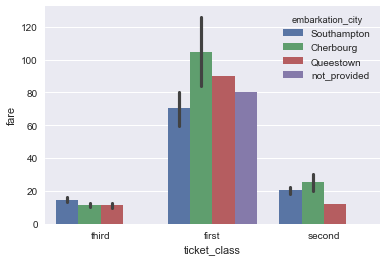

In [80]:
sns.barplot(x='ticket_class', y='fare', hue='embarkation_city', data=data_titanic)

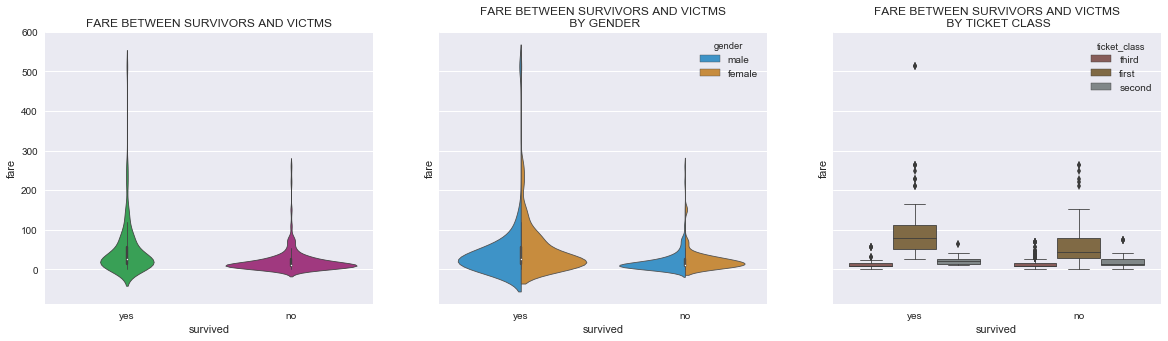

In [64]:
fig_fare_violin, ax_fare_violin = plt.subplots(1,3, sharex='col', sharey='row', figsize=(20,5))

sns.violinplot(x='survived', y='fare', order=['yes','no'],\
               data=data_titanic, palette=palette_destiny, linewidth=0.8, ax=ax_fare_violin[0]\
              ).set_title('Fare between survivors and victms'.upper())

sns.violinplot(x='survived', y='fare', order=['yes','no'], hue='gender', ax=ax_fare_violin[1], \
               data=data_titanic, palette=palette_destiny_gender, linewidth=0.8, split=True\
              ).set_title('Fare between survivors and victms\n by gender'.upper())

sns.boxplot(x='survived', y='fare', order=['yes','no'], hue='ticket_class',\
            data=data_titanic, palette=palette_destiny_classes, linewidth=0.8, ax=ax_fare_violin[2]\
           ).set_title('Fare between survivors and victms\n by ticket class'.upper())

fig_fare_violin.show()

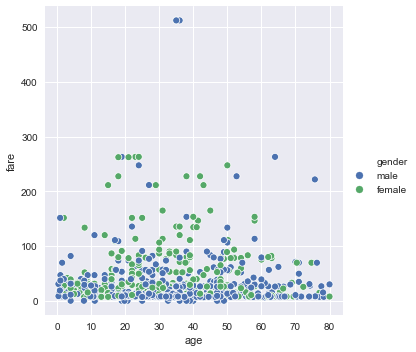

In [76]:
# sns.jointplot(x='age', y='fare', data=data_titanic)
sns.relplot(x='age', y='fare', hue='gender', data=data_titanic)

In [48]:
# sns.jointplot(x='survived', y='fare', data=data_titanic)

>age >fare


In [ ]:

# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(data_titanic['fare'])

figure_costs, ax_costs = plt.subplots(1,3)
# sns.distplot(data_titanic['fare'], hue='fare')

# a = sns.distplot(data_titanic['fare'], ax=ax_costs[0])
# pf.set_title(a, 'first')x='ticket_class', 

b = sns.violinplot(x='survived', y='fare', data=data_titanic, ax=ax_costs[1])
pf.set_title(b, 'second')

# b.legend()
# sns.pairplot(data_titanic)
# data_titanic.query('fare == 0')

figure_costs.show()

In [ ]:
ds, df = data_titanic['survived'].apply(lambda x: 1 if x == 'yes' else 0), data_titanic['fare']
dsf = ds.to_frame().join(df)
sns.clustermap(dsf)

**Critérios**:
- "Faça testes e sugira perguntas que promovam olhar para relacionamentos entre múltiplas variáveis"
- "Você deve analisar pelo menos uma variável dependente e três variáveis ​​independentes em sua investigação"
- "Uma definição de qual pergunta você fez"
- "Uma nota especificando qual foi o conjunto de dados usado"
- "Uma descrição do que você fez para investigar a pergunta"
Um PDF ou HTML contendo sua análise. Este arquivo deve conter:


Descrição de qualquer limpeza de dados feita  
Um resumo das estatísticas e gráficos comunicando seu resultado final  
O código usado para criar suas análises. Se você usou um notebook iPython, pode enviar seu .ipynb. Caso não o tenha feito, encaminhe os arquivos .py.



Para obter maior compreensão dos dados, segue uma descrição... ?? 

### Referências

##### Fonte
- [Kaggle - Titanic](https://www.kaggle.com/c/titanic/data)

##### Conteúdos sobre Titanic:
- [Em naufrágios, crianças e mulheres têm mesmo prioridade?](https://super.abril.com.br/mundo-estranho/em-naufragios-criancas-e-mulheres-tem-mesmo-prioridade/)
- [Em naufrágios e outros desastres, mulheres e crianças só conseguem sair por último](http://revistagalileu.globo.com/Revista/Common/0,,EMI302308-17770,00-EM+NAUFRAGIOS+E+OUTROS+DESASTRES+MULHERES+E+CRIANCAS+SO+CONSEGUEM+SAIR+POR+.html)
- [Nerdologia - Titanic](https://www.youtube.com/watch?v=GlEV_2qbvx8)


##### Análises de dados
- [Lautert, Larissa. Análise exploratória da fila - hacking-health-sc-2017](https://github.com/llautert/hacking-health-sc-2017/blob/master/An%C3%A1lise%20explorat%C3%B3ria%20da%20fila.ipynb)
- [Reis, Filipe - T2 - Análise Exploratória de Dados - Filipe Reis - RA091202](https://github.com/fireis/ia369w_exp_data_ana/blob/master/T2%20-%20Saude%20-%20Filipe%20Reis%20-%20RA091202.ipynb)
- [Siqueira, Fernando - Análise de notas de alunos](https://github.com/fernandolkf/dotdigitalgroup/blob/master/dotdigitalgroup.ipynb)


##### Técnicos
- [Handling missing data](https://www.oreilly.com/learning/handling-missing-data)
- [Mean Median Mode lines showing only in last graph in seaborn](https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn/51417635)

- [A collection of various notebook extensions for Jupyter](https://github.com/ipython-contrib/jupyter_contrib_nbextensions)
- [Python for Data Science and Machine Learning Bootcamp](https://www.udemy.com/python-for-data-science-and-machine-learning-bootcamp)